In [1]:
# General
import warnings
warnings.filterwarnings("ignore")

# Create circuit to test transpiler on
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

In [3]:
# oracle = Diagonal([1] * 7 + [-1])
# qc = QuantumCircuit(3)
# qc.h([0, 1, 2])
# qc = qc.compose(GroverOperator(oracle))

# qc.draw(output="mpl", style="iqp")


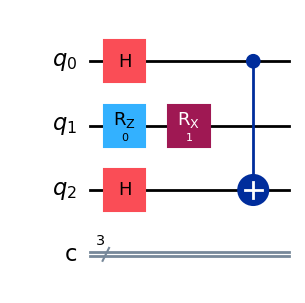

In [3]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(3, 3)
qc.rz(0,1)
qc.rx(1,1)
qc.h([0,2])
qc.cx(0, 2)


display(qc.draw("mpl", style="iqp"))

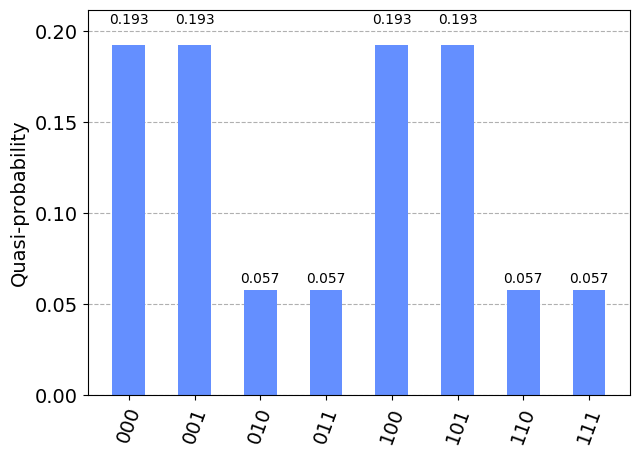

In [4]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

In [5]:
print(qc.count_ops())


OrderedDict([('h', 2), ('rz', 1), ('rx', 1), ('cx', 1)])


In [6]:
# Need to add measurements to the circuit
qc.measure_all()

circuits = []
for optimization_level in [0, 3]:
    t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
    print(f"CNOTs (optimization_level={optimization_level}): ", t_qc.count_ops()["rz"])
    circuits.append(t_qc)

CNOTs (optimization_level=0):  36
CNOTs (optimization_level=3):  10


In [7]:
from qiskit.transpiler import PassManager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

# Get gate durations so the transpiler knows how long each operation takes
durations = backend.target.durations()

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm = PassManager([ASAPScheduleAnalysis(durations), PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circuits[1])

# Add this new circuit to our list
circuits.append(circ_dd)

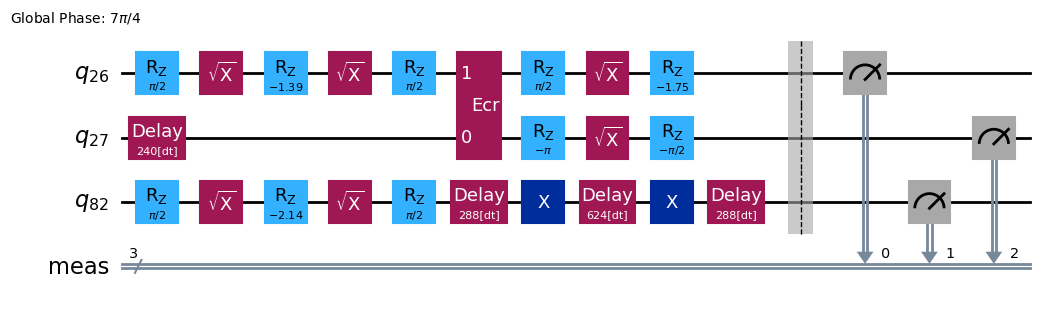

In [8]:
circ_dd.draw(output="mpl", style="iqp", idle_wires=False)

In [9]:
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=circuits,  # sample all three circuits
        skip_transpilation=True,
        shots=8000,
    )
    result = job.result()

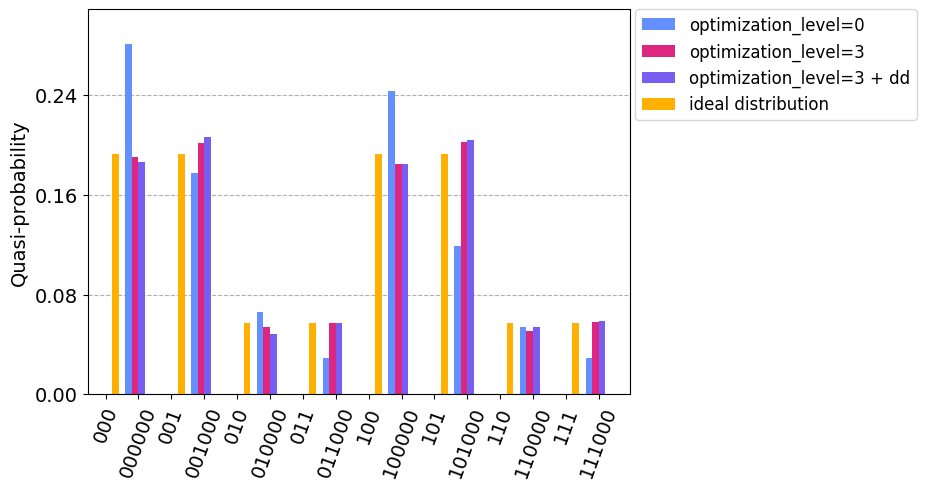

In [10]:
binary_prob = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
plot_histogram(
    binary_prob + [ideal_distribution],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "optimization_level=3 + dd",
        "ideal distribution",
    ],
)

In [12]:
from qiskit.quantum_info import hellinger_fidelity

for counts in result.quasi_dists:
    print(f"{hellinger_fidelity(counts.binary_probabilities(), ideal_distribution):.3f}")

0.000
0.000
0.000
